<div style = "height: 50px;"></div>

# 필요한 모듈 불러오기

In [1]:
import warnings
import pandas              as pd
import matplotlib.pyplot   as plt
import numpy               as np
import tensorflow          as tf
import tensorflow_datasets as tfds

from tensorflow import keras

warnings.simplefilter("ignore")

In [2]:
# GPU 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

<div style = "height: 50px;"></div>

# <span style = "font-weight:bold;color:#0172d4;">STEP 1</span> 데이터 불러오기

## 데이터셋 확인하기
<hr/>

In [3]:
# 데이터 불러오기
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs',
                                         split = ['train', 'test'],
                                         shuffle_files = True,
                                         with_info = True)

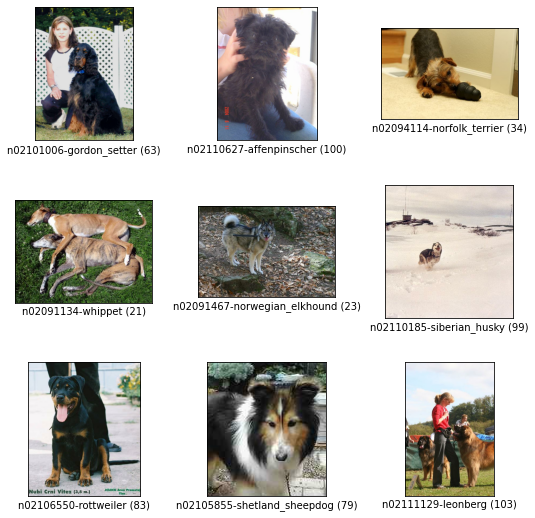

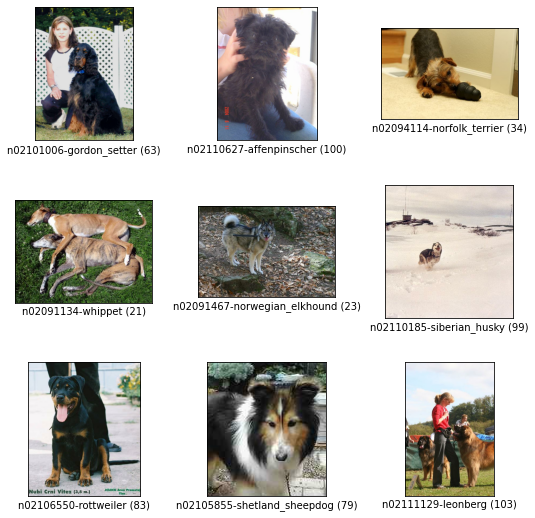

In [4]:
# 데이터 확인
tfds.show_examples(ds_train, ds_info)

<div style = "height: 50px;"></div>

## 이미지 전처리 함수 
<hr/>

In [5]:
# 이미지 전처리 함수
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [6]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)

    # image_tensor = tf.keras.preprocessing.image.img_to_array(image)
    image = tf.image.random_hue(image, max_delta= 0.5)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=64, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(augment)
    ds = ds.batch(batch_size)

    if not is_test and with_cutmix:
        ds = ds.map(cutmix, num_parallel_calls=2)
    
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
        
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

<div style = "height: 50px;"></div>

## 데이터 전처리하여 불러오기
<hr/>

In [7]:
num_classes = ds_info.features["label"].num_classes

In [8]:
# 데이터 불러오기
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

<div style = "height: 50px;"></div>

# <span style = "font-weight:bold;color:#0172d4;">STEP 2</span> Cutmix Augmentation

## 1. 이미지 섞기
<hr/>

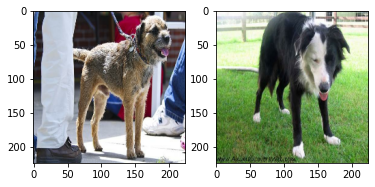

In [9]:
# tfds에서 2장을 가져옴
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [10]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1 - tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1 - tf.random.uniform([], 0, 1)), tf.int32)
    
    # 자를 박스의 모서리 4개 점을 구함. 
    x_min = tf.math.maximum(0, x - width // 2)
    y_min = tf.math.maximum(0, y - height // 2)
    x_max = tf.math.minimum(image_size_x, x + width // 2)
    y_max = tf.math.minimum(image_size_y, y + width // 2)
    
    return x_min, y_min, x_max, y_max

In [11]:
# 구한 점 위치를 이용하여 박스 영역을 생성
x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(100, shape=(), dtype=int32)
y :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(105, shape=(), dtype=int32)


In [12]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

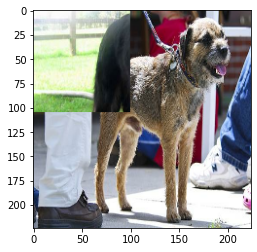

In [13]:
mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

<div style = "height: 50px;"></div>

## 2. 라벨 섞기
<hr/>

In [14]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [15]:
mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.7907366, 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
   

<div style = "height: 50px;"></div>

## 3. cutmix 함수 구현
<hr/>

In [16]:
def cutmix(image, label, prob=1.0, batch_size=32, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [17]:
mixed_imgs, mixed_labels = cutmix(image, label)

In [18]:
plt.figure(figsize=(20,20))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(mixed_imgs[i])


plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

<div style = "height: 50px;"></div>

# <span style = "font-weight:bold;color:#0172d4;">STEP 3</span> Mixup Augmentation

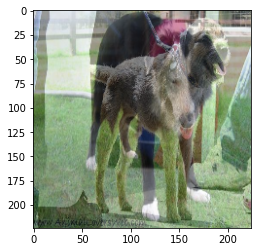

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.44251513 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.55748487 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [19]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [20]:
def mixup(image, label, prob=1.0, batch_size=32, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

<div style = "height: 50px;"></div>

# <span style = "font-weight:bold;color:#0172d4;">STEP 4</span> 여러가지 Augmentation 기법을 적용해보기

## 1차 - Plain data VS CutMix data 비교
<hr/>

<ul>
    <li>batch_size : 16</li>
    <li>augmentation : 밝기조절 (max_delta=0.2), 랜덤 좌우 뒤집기</li>
    <li>lr : 0.01</li>
    <li>EPOCH : 20</li>
</ul>

### 모델 build

In [19]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


In [20]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

<div style = "height: 50px;"></div>

### 데이터 전처리하여 불러오기

In [21]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train = apply_normalize_on_dataset(ds_train)\
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

<div style = "height: 50px;"></div>

### resnet50(plain) 모델 훈련

In [ ]:
# plain 모델
EPOCH = 20

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50 = resnet50.fit(
    ds_train, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 109s 121ms/step - loss: 2.2073 - accuracy: 0.4514 - val_loss: 3.4843 - val_accuracy: 0.1938
Epoch 2/20
750/750 [==============================] - 89s 119ms/step - loss: 0.6795 - accuracy: 0.8141 - val_loss: 1.1281 - val_accuracy: 0.6727
Epoch 3/20
750/750 [==============================] - 89s 119ms/step - loss: 0.2667 - accuracy: 0.9419 - val_loss: 0.9627 - val_accuracy: 0.7199
Epoch 4/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0699 - accuracy: 0.9916 - val_loss: 0.9130 - val_accuracy: 0.7383
Epoch 5/20
750/750 [==============================] - 94s 125ms/step - loss: 0.0222 - accuracy: 0.9994 - val_loss: 0.9140 - val_accuracy: 0.7381
Epoch 6/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0120 - accuracy: 0.9998 - val_loss: 0.9220 - val_accuracy: 0.7397
Epoch 7/20
750/750 [==============================] - 89s 119ms/step - loss: 0.0089 - accuracy: 0.9998 - val_loss: 0.9310 - val_a

<div style = "height: 50px;"></div>

### resnet50(cutmix, no_aug)

In [ ]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 100s 122ms/step - loss: 3.7623 - accuracy: 0.2259 - val_loss: 2.9338 - val_accuracy: 0.2706
Epoch 2/20
750/750 [==============================] - 91s 121ms/step - loss: 2.9423 - accuracy: 0.4311 - val_loss: 1.4924 - val_accuracy: 0.5915
Epoch 3/20
750/750 [==============================] - 97s 129ms/step - loss: 2.6482 - accuracy: 0.5247 - val_loss: 1.7174 - val_accuracy: 0.5374
Epoch 4/20
750/750 [==============================] - 93s 124ms/step - loss: 2.4243 - accuracy: 0.5999 - val_loss: 1.2509 - val_accuracy: 0.6531
Epoch 5/20
750/750 [==============================] - 93s 124ms/step - loss: 2.2495 - accuracy: 0.6548 - val_loss: 1.3195 - val_accuracy: 0.6439
Epoch 6/20
750/750 [==============================] - 93s 124ms/step - loss: 2.1636 - accuracy: 0.6929 - val_loss: 1.2215 - val_accuracy: 0.6644
Epoch 7/20
750/750 [==============================] - 97s 129ms/step - loss: 2.0500 - accuracy: 0.7172 - val_loss: 1.1949 - val_a

<div style = "height: 50px;"></div>

### 시각화 및 비교

In [ ]:
plt.plot(history_resnet50.history['val_loss'], 'r')
plt.plot(history_cutmix.history['val_loss'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation, No MixUp', 'No Augmentation With MixUp'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_ds_train_no_cutmix.history['val_loss'], 'r')
plt.plot(history_cutmix.history['val_loss'], 'b')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

sadasdasdas

<div style = "height: 55px;"></div>

#### why? 이유 생각해보기


실제 cutmix가 적용되는 예시를 확인해보면 강아지 얼굴에 고양이 얼굴을 붙여넣어 다른 사진을 만들었으나, lms에서 진행한 cutmix를 확인해보면 데이터들의 구도 (사진들)가 각각 다르고, 객체의 수 (한 사진에서의 강아지 수)도 다르며, 실제 적용했을 때 아래 사진처럼 알수없는 부분의 사진이 합성된 것을 확인할 수 있었다. 이는, 모델 학습에 오히려 방해가 된다고 판단하였다.

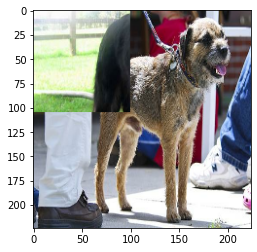

In [13]:
mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

#### 실제 예시 

<img src = "img/05.jpeg" style = "width: 70%;">

<div style = "height: 50px;"></div>

## 2차 - Plain data VS MixUp data 비교
<hr/>

<ul>
    <li>batch_size : 16</li>
    <li>augmentation : 밝기조절 (max_delta=0.2), 랜덤 좌우 뒤집기</li>
    <li>lr : 0.01</li>
    <li>EPOCH : 20</li>
</ul>

### 모델 build

In [19]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
no_aug_mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

<div style = "height: 50px;"></div>

### 데이터 전처리하여 불러오기

In [32]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_aug    = apply_normalize_on_dataset(ds_train, with_aug = True)
ds_train_mixup  = apply_normalize_on_dataset(ds_train, with_mixup = True)
ds_train        = apply_normalize_on_dataset(ds_train)
ds_test         = apply_normalize_on_dataset(ds_test, is_test=True)

<div style = "height: 50px;"></div>

### resnet50(plain) 모델 훈련

In [26]:
EPOCH = 20 

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50 = resnet50.fit(
    ds_train, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 108s 120ms/step - loss: 2.2214 - accuracy: 0.4388 - val_loss: 3.3451 - val_accuracy: 0.2067
Epoch 2/20
750/750 [==============================] - 88s 117ms/step - loss: 0.7497 - accuracy: 0.7914 - val_loss: 1.1160 - val_accuracy: 0.6785
Epoch 3/20
750/750 [==============================] - 89s 118ms/step - loss: 0.2498 - accuracy: 0.9460 - val_loss: 0.9491 - val_accuracy: 0.7144
Epoch 4/20
750/750 [==============================] - 88s 118ms/step - loss: 0.0726 - accuracy: 0.9923 - val_loss: 0.9031 - val_accuracy: 0.7429
Epoch 5/20
750/750 [==============================] - 88s 118ms/step - loss: 0.0237 - accuracy: 0.9992 - val_loss: 0.8971 - val_accuracy: 0.7474
Epoch 6/20
750/750 [==============================] - 88s 118ms/step - loss: 0.0131 - accuracy: 0.9998 - val_loss: 0.9090 - val_accuracy: 0.7477
Epoch 7/20
750/750 [==============================] - 89s 118ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.9201 - val_a

<div style = "height: 50px;"></div>

### resnet50(mixup, no_aug)

In [33]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

no_aug_mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_no_aug_mixup = no_aug_mixup_resnet50.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 97s 121ms/step - loss: 3.7092 - accuracy: 0.2427 - val_loss: 3.9223 - val_accuracy: 0.1357
Epoch 2/20
750/750 [==============================] - 90s 120ms/step - loss: 2.8515 - accuracy: 0.4796 - val_loss: 1.4916 - val_accuracy: 0.5823
Epoch 3/20
750/750 [==============================] - 91s 122ms/step - loss: 2.5823 - accuracy: 0.5839 - val_loss: 1.3607 - val_accuracy: 0.6209
Epoch 4/20
750/750 [==============================] - 90s 121ms/step - loss: 2.4314 - accuracy: 0.6473 - val_loss: 1.4416 - val_accuracy: 0.6017
Epoch 5/20
750/750 [==============================] - 91s 121ms/step - loss: 2.2600 - accuracy: 0.7048 - val_loss: 1.3367 - val_accuracy: 0.6433
Epoch 6/20
750/750 [==============================] - 91s 121ms/step - loss: 2.1760 - accuracy: 0.7408 - val_loss: 1.3236 - val_accuracy: 0.6416
Epoch 7/20
750/750 [==============================] - 91s 121ms/step - loss: 2.0610 - accuracy: 0.7742 - val_loss: 1.2461 - val_ac

<div style = "height: 50px;"></div>

### 시각화 및 비교

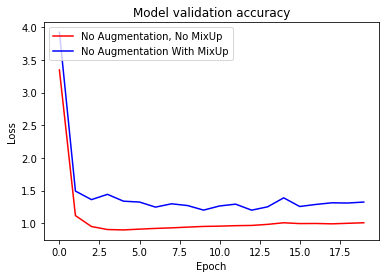

In [36]:
plt.plot(history_resnet50.history['val_loss'], 'r')
plt.plot(history_no_aug_mixup.history['val_loss'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation, No MixUp', 'No Augmentation With MixUp'], loc='upper left')
plt.show()

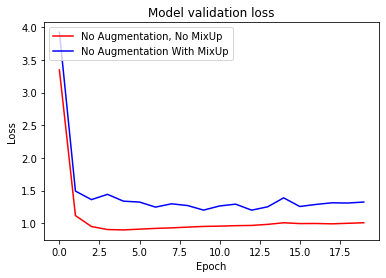

In [38]:
plt.plot(history_resnet50.history['val_loss'], 'r')
plt.plot(history_no_aug_mixup.history['val_loss'], 'b')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation, No MixUp', 'No Augmentation With MixUp'], loc='upper left')
plt.show()

cutmix와 마찬가지로, 적용한 모델의 성능이 더 좋을 것이라는 예상과는 달리, 아무것도 적용하지 않은 모델보다 성능이 많이 떨어진 것을 확인하였다.

<div style = "height: 50px;"></div>

## 3차 - Plain data, Aug data, CutMix data, MixUp data 비교
<hr/>

<ul>
    <li>batch_size : 16</li>
    <li>augmentation : 밝기조절 (max_delta=0.2), 랜덤 좌우 뒤집기</li>
    <li>lr : 0.01</li>
    <li>EPOCH : 20</li>
</ul>

### 모델 build

In [21]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [22]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [23]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [24]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

<div style = "height: 50px;"></div>

### 데이터 전처리하여 불러오기

In [26]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_aug    = apply_normalize_on_dataset(ds_train, with_aug = True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup  = apply_normalize_on_dataset(ds_train, with_mixup = True)
ds_train        = apply_normalize_on_dataset(ds_train)
# ds_train_all    = apply_normalize_on_dataset(ds_train, with_aug = True, with_cutmix = True, with_mixup = True)
ds_test         = apply_normalize_on_dataset(ds_test, is_test=True)

<div style = "height: 50px;"></div>

### resnet50(plain) 모델 훈련

In [27]:
EPOCH = 20 

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.001),
    metrics=['accuracy'],
)

history_resnet50 = resnet50.fit(
    ds_train, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 99s 119ms/step - loss: 4.4300 - accuracy: 0.0850 - val_loss: 4.5563 - val_accuracy: 0.0535
Epoch 2/20
750/750 [==============================] - 88s 118ms/step - loss: 2.8707 - accuracy: 0.3957 - val_loss: 2.1643 - val_accuracy: 0.4894
Epoch 3/20
750/750 [==============================] - 88s 118ms/step - loss: 1.9576 - accuracy: 0.5749 - val_loss: 1.6067 - val_accuracy: 0.5935
Epoch 4/20
750/750 [==============================] - 89s 118ms/step - loss: 1.4362 - accuracy: 0.6835 - val_loss: 1.3714 - val_accuracy: 0.6333
Epoch 5/20
750/750 [==============================] - 93s 124ms/step - loss: 1.0962 - accuracy: 0.7695 - val_loss: 1.2284 - val_accuracy: 0.6635
Epoch 6/20
750/750 [==============================] - 93s 124ms/step - loss: 0.8606 - accuracy: 0.8281 - val_loss: 1.1388 - val_accuracy: 0.6791
Epoch 7/20
750/750 [==============================] - 89s 118ms/step - loss: 0.6797 - accuracy: 0.8822 - val_loss: 1.0864 - val_ac

<div style = "height: 50px;"></div>

### resnet50(aug)

In [28]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.001),
    metrics=['accuracy'],
)

history_aug_resnet50 = aug_resnet50.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 98s 119ms/step - loss: 4.4599 - accuracy: 0.0808 - val_loss: 4.4584 - val_accuracy: 0.0681
Epoch 2/20
750/750 [==============================] - 88s 118ms/step - loss: 2.9887 - accuracy: 0.3540 - val_loss: 2.1364 - val_accuracy: 0.5000
Epoch 3/20
750/750 [==============================] - 88s 118ms/step - loss: 2.0678 - accuracy: 0.5386 - val_loss: 1.5980 - val_accuracy: 0.5970
Epoch 4/20
750/750 [==============================] - 89s 118ms/step - loss: 1.5944 - accuracy: 0.6252 - val_loss: 1.3519 - val_accuracy: 0.6430
Epoch 5/20
750/750 [==============================] - 88s 118ms/step - loss: 1.2919 - accuracy: 0.6955 - val_loss: 1.1937 - val_accuracy: 0.6695
Epoch 6/20
750/750 [==============================] - 89s 118ms/step - loss: 1.0904 - accuracy: 0.7402 - val_loss: 1.1024 - val_accuracy: 0.6883
Epoch 7/20
750/750 [==============================] - 89s 119ms/step - loss: 0.9233 - accuracy: 0.7830 - val_loss: 1.0563 - val_ac

<div style = "height: 50px;"></div>

### resnet50(cutmix)

In [29]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.001),
    metrics=['accuracy'],
)

history_cutmix_resnet50 = cutmix_resnet50.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 99s 121ms/step - loss: 4.8509 - accuracy: 0.0224 - val_loss: 5.1476 - val_accuracy: 0.0250
Epoch 2/20
750/750 [==============================] - 89s 119ms/step - loss: 4.3500 - accuracy: 0.1038 - val_loss: 3.1647 - val_accuracy: 0.2958
Epoch 3/20
750/750 [==============================] - 90s 120ms/step - loss: 3.8844 - accuracy: 0.2177 - val_loss: 2.4236 - val_accuracy: 0.4264
Epoch 4/20
750/750 [==============================] - 90s 120ms/step - loss: 3.5542 - accuracy: 0.3039 - val_loss: 1.9462 - val_accuracy: 0.5175
Epoch 5/20
750/750 [==============================] - 94s 126ms/step - loss: 3.3838 - accuracy: 0.3458 - val_loss: 1.6962 - val_accuracy: 0.5689
Epoch 6/20
750/750 [==============================] - 90s 120ms/step - loss: 3.2052 - accuracy: 0.3970 - val_loss: 1.4985 - val_accuracy: 0.6077
Epoch 7/20
750/750 [==============================] - 90s 120ms/step - loss: 3.0913 - accuracy: 0.4264 - val_loss: 1.4052 - val_ac

<div style = "height: 50px;"></div>

### resnet50(mixup)

In [30]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.001),
    metrics=['accuracy'],
)

history_mixup_resnet50 = mixup_resnet50.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 99s 121ms/step - loss: 4.8225 - accuracy: 0.0268 - val_loss: 5.1970 - val_accuracy: 0.0246
Epoch 2/20
750/750 [==============================] - 90s 120ms/step - loss: 4.2175 - accuracy: 0.1310 - val_loss: 2.9799 - val_accuracy: 0.3039
Epoch 3/20
750/750 [==============================] - 90s 120ms/step - loss: 3.6930 - accuracy: 0.2716 - val_loss: 2.1984 - val_accuracy: 0.4525
Epoch 4/20
750/750 [==============================] - 90s 120ms/step - loss: 3.3480 - accuracy: 0.3664 - val_loss: 1.7894 - val_accuracy: 0.5366
Epoch 5/20
750/750 [==============================] - 90s 120ms/step - loss: 3.1236 - accuracy: 0.4262 - val_loss: 1.5446 - val_accuracy: 0.5883
Epoch 6/20
750/750 [==============================] - 90s 120ms/step - loss: 2.9881 - accuracy: 0.4642 - val_loss: 1.4102 - val_accuracy: 0.6118
Epoch 7/20
750/750 [==============================] - 90s 120ms/step - loss: 2.8742 - accuracy: 0.4962 - val_loss: 1.3095 - val_ac

<div style = "height: 50px;"></div>

### 시각화 및 비교

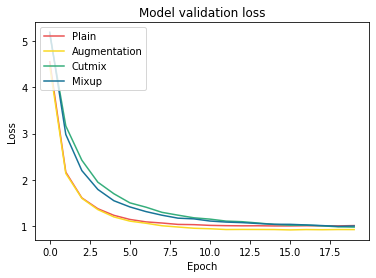

In [32]:
plt.plot(history_resnet50.history['val_loss'], color = '#EB5353')
plt.plot(history_aug_resnet50.history['val_loss'], color = '#F9D923')
plt.plot(history_cutmix_resnet50.history['val_loss'], color = '#36AE7C')
plt.plot(history_mixup_resnet50.history['val_loss'], color = '#187498')
# plt.plot(history_all_resnet50.history['val_loss'], color = '#542E71')

plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Plain', 'Augmentation', 'Cutmix', 'Mixup'], loc='upper left')
plt.show()

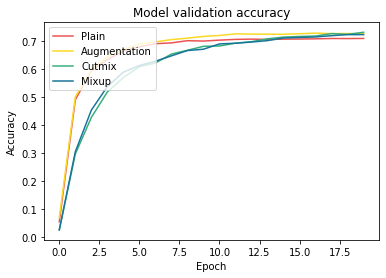

In [36]:
plt.plot(history_resnet50.history['val_accuracy'], color = '#EB5353')
plt.plot(history_aug_resnet50.history['val_accuracy'], color = '#F9D923')
plt.plot(history_cutmix_resnet50.history['val_accuracy'], color = '#36AE7C')
plt.plot(history_mixup_resnet50.history['val_accuracy'], color = '#187498')
# plt.plot(history_all_resnet50.history['val_accuracy'], color = '#542E71')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain', 'Augmentation', 'Cutmix', 'Mixup'], loc='upper left')
plt.show()

#### 순위 (최종 epoch 기준 / val_accuracy)
1. cutmix - 0.7309
2. aug data - 0.7253
3. mixup - 0.7224
4. plain - 0.7087

<div style = "height: 50px;"></div>

## 4차 - 하이퍼 파라미터 조정해보기
<hr/>

<ul>
    <li>batch_size : 64</li>
    <li>augmentation : 밝기조절 (max_delta=0.2), 랜덤 좌우 뒤집기</li>
    <li>lr : 0.01</li>
    <li>EPOCH : 20</li>
</ul>

### 모델 build

In [21]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [22]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [23]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [24]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

<div style = "height: 50px;"></div>

### 데이터 전처리하여 불러오기

In [26]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_aug    = apply_normalize_on_dataset(ds_train, with_aug = True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup  = apply_normalize_on_dataset(ds_train, with_mixup = True)

ds_train        = apply_normalize_on_dataset(ds_train)
ds_test         = apply_normalize_on_dataset(ds_test, is_test=True)

<div style = "height: 50px;"></div>

### resnet50(plain) 모델 훈련

In [27]:
EPOCH = 20

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50 = resnet50.fit(
    ds_train, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/64),
    validation_steps=int(ds_info.splits['test'].num_examples/64),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
187/187 [==============================] - 97s 378ms/step - loss: 3.2511 - accuracy: 0.3112 - val_loss: 5.4203 - val_accuracy: 0.0077
Epoch 2/20
187/187 [==============================] - 69s 370ms/step - loss: 1.2525 - accuracy: 0.7060 - val_loss: 5.0334 - val_accuracy: 0.0111
Epoch 3/20
187/187 [==============================] - 69s 369ms/step - loss: 0.6952 - accuracy: 0.8432 - val_loss: 4.9618 - val_accuracy: 0.0152
Epoch 4/20
187/187 [==============================] - 69s 370ms/step - loss: 0.4098 - accuracy: 0.9230 - val_loss: 3.3101 - val_accuracy: 0.2220
Epoch 5/20
187/187 [==============================] - 69s 369ms/step - loss: 0.2449 - accuracy: 0.9651 - val_loss: 1.5886 - val_accuracy: 0.5627
Epoch 6/20
187/187 [==============================] - 69s 372ms/step - loss: 0.1378 - accuracy: 0.9906 - val_loss: 1.0688 - val_accuracy: 0.6908
Epoch 7/20
187/187 [==============================] - 69s 371ms/step - loss: 0.1114 - accuracy: 0.9936 - val_loss: 0.9829 - val_ac

<div style = "height: 50px;"></div>

### resnet50(aug)

In [28]:
EPOCH = 20

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_aug_resnet50 = aug_resnet50.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/64),
    validation_steps=int(ds_info.splits['test'].num_examples/64),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
187/187 [==============================] - 90s 374ms/step - loss: 3.3871 - accuracy: 0.2769 - val_loss: 5.3206 - val_accuracy: 0.0091
Epoch 2/20
187/187 [==============================] - 69s 370ms/step - loss: 1.4159 - accuracy: 0.6499 - val_loss: 5.0338 - val_accuracy: 0.0062
Epoch 3/20
187/187 [==============================] - 69s 370ms/step - loss: 0.8663 - accuracy: 0.7761 - val_loss: 4.8412 - val_accuracy: 0.0253
Epoch 4/20
187/187 [==============================] - 69s 371ms/step - loss: 0.6268 - accuracy: 0.8438 - val_loss: 2.6132 - val_accuracy: 0.3401
Epoch 5/20
187/187 [==============================] - 69s 371ms/step - loss: 0.4350 - accuracy: 0.8978 - val_loss: 1.4031 - val_accuracy: 0.6065
Epoch 6/20
187/187 [==============================] - 69s 371ms/step - loss: 0.3036 - accuracy: 0.9401 - val_loss: 1.1053 - val_accuracy: 0.6727
Epoch 7/20
187/187 [==============================] - 69s 370ms/step - loss: 0.2149 - accuracy: 0.9638 - val_loss: 0.9869 - val_ac

<div style = "height: 50px;"></div>

### resnet50(cutmix)

In [29]:
EPOCH = 20

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_cutmix_resnet50 = cutmix_resnet50.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/64),
    validation_steps=int(ds_info.splits['test'].num_examples/64),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/20
187/187 [==============================] - 66s 247ms/step - loss: 4.5156 - accuracy: 0.0839 - val_loss: 5.4660 - val_accuracy: 0.0114
Epoch 2/20
187/187 [==============================] - 44s 237ms/step - loss: 3.6010 - accuracy: 0.2739 - val_loss: 5.3162 - val_accuracy: 0.0100
Epoch 3/20
187/187 [==============================] - 45s 242ms/step - loss: 3.2053 - accuracy: 0.3708 - val_loss: 4.8860 - val_accuracy: 0.0257
Epoch 4/20
187/187 [==============================] - 44s 238ms/step - loss: 2.9847 - accuracy: 0.4332 - val_loss: 3.0151 - val_accuracy: 0.2603
Epoch 5/20
187/187 [==============================] - 45s 238ms/step - loss: 2.7949 - accuracy: 0.4916 - val_loss: 1.7060 - val_accuracy: 0.5414
Epoch 6/20
187/187 [==============================] - 46s 244ms/step - loss: 2.6662 - accuracy: 0.5326 - val_loss: 1.3226 - val_accuracy: 0.6507
Epoch 7/20
187/187 [==============================] - 45s 239ms/step - loss: 2.6134 - accuracy: 0.5391 - val_loss: 1.2305 - val_ac

<div style = "height: 50px;"></div>

### resnet50(mixup)

In [30]:
EPOCH = 20

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_mixup_resnet50 = mixup_resnet50.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/64),
    validation_steps=int(ds_info.splits['test'].num_examples/64),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
187/187 [==============================] - 72s 285ms/step - loss: 4.4250 - accuracy: 0.1110 - val_loss: 7.0903 - val_accuracy: 0.0129
Epoch 2/20
187/187 [==============================] - 45s 243ms/step - loss: 3.3493 - accuracy: 0.3351 - val_loss: 5.1886 - val_accuracy: 0.0058
Epoch 3/20
187/187 [==============================] - 45s 240ms/step - loss: 2.9683 - accuracy: 0.4522 - val_loss: 5.0248 - val_accuracy: 0.0097
Epoch 4/20
187/187 [==============================] - 45s 241ms/step - loss: 2.8107 - accuracy: 0.5135 - val_loss: 3.6788 - val_accuracy: 0.1694
Epoch 5/20
187/187 [==============================] - 46s 244ms/step - loss: 2.6419 - accuracy: 0.5675 - val_loss: 1.9250 - val_accuracy: 0.5073
Epoch 6/20
187/187 [==============================] - 45s 241ms/step - loss: 2.5386 - accuracy: 0.6016 - val_loss: 1.5491 - val_accuracy: 0.5882
Epoch 7/20
187/187 [==============================] - 45s 243ms/step - loss: 2.4922 - accuracy: 0.6280 - val_loss: 1.2665 - val_ac

<div style = "height: 50px;"></div>

### 시각화 및 비교

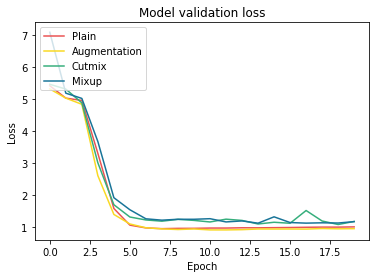

In [32]:
plt.plot(history_resnet50.history['val_loss'], color = '#EB5353')
plt.plot(history_aug_resnet50.history['val_loss'], color = '#F9D923')
plt.plot(history_cutmix_resnet50.history['val_loss'], color = '#36AE7C')
plt.plot(history_mixup_resnet50.history['val_loss'], color = '#187498')
# plt.plot(history_aug_resnet50_2.history['val_loss'], color = '#542E71')

plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Plain', 'Augmentation', 'Cutmix', 'Mixup'], loc='upper left')
plt.show()

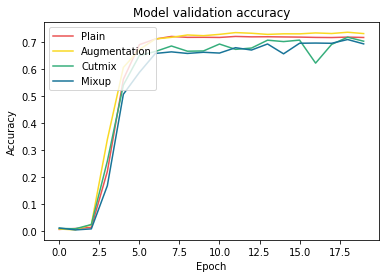

In [33]:
plt.plot(history_resnet50.history['val_accuracy'], color = '#EB5353')
plt.plot(history_aug_resnet50.history['val_accuracy'], color = '#F9D923')
plt.plot(history_cutmix_resnet50.history['val_accuracy'], color = '#36AE7C')
plt.plot(history_mixup_resnet50.history['val_accuracy'], color = '#187498')
# plt.plot(history_aug_resnet50_2.history['val_accuracy'], color = '#542E71')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain', 'Augmentation', 'Cutmix', 'Mixup'], loc='upper left')
plt.show()

#### 순위 (최종 epoch 기준 / val_accuracy)
1. aug data - 0.7317
2. plain - 0.7172
3. cutmix - 0.7035
4. mixup - 0.6936

<div style = "height: 50px;"></div>

## 5차 - Augmentation 새롭게 적용해보기
<hr/>

<ul>
    <li>batch_size : 64</li>
    <li>augmentation : 밝기조절 (max_delta=0.2), 랜덤 좌우 뒤집기, 랜덤 hue 조정(max_delta= 0.5)</li>
    <li>lr : 0.01</li>
    <li>EPOCH : 20</li>
</ul>

### Augmentation 함수 조정

In [35]:
def augment2(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    image = tf.image.random_hue(image, max_delta= 0.5)
    return image, label

In [36]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=64, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(augment2)
    ds = ds.batch(batch_size)

    if not is_test and with_cutmix:
        ds = ds.map(cutmix, num_parallel_calls=2)
    
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
        
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

<div style = "height: 50px;"></div>

### 모델 build

In [37]:
aug_resnet50_2 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

<div style = "height: 50px;"></div>

### 데이터 전처리하여 불러오기

In [38]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_aug_2  = apply_normalize_on_dataset(ds_train, with_aug = True)
ds_test         = apply_normalize_on_dataset(ds_test, is_test=True)

<div style = "height: 50px;"></div>

### resnet50(aug2) 모델 훈련

In [39]:
EPOCH = 20

aug_resnet50_2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_aug_resnet50_2 = aug_resnet50_2.fit(
    ds_train_aug_2,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/64),
    validation_steps=int(ds_info.splits['test'].num_examples/64),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
187/187 [==============================] - 94s 376ms/step - loss: 3.3613 - accuracy: 0.2708 - val_loss: 5.1734 - val_accuracy: 0.0057
Epoch 2/20
187/187 [==============================] - 71s 383ms/step - loss: 1.4373 - accuracy: 0.6301 - val_loss: 5.0044 - val_accuracy: 0.0062
Epoch 3/20
187/187 [==============================] - 69s 371ms/step - loss: 0.9429 - accuracy: 0.7511 - val_loss: 4.9448 - val_accuracy: 0.0146
Epoch 4/20
187/187 [==============================] - 69s 371ms/step - loss: 0.6982 - accuracy: 0.8150 - val_loss: 3.1637 - val_accuracy: 0.2499
Epoch 5/20
187/187 [==============================] - 69s 372ms/step - loss: 0.5482 - accuracy: 0.8585 - val_loss: 1.3871 - val_accuracy: 0.6003
Epoch 6/20
187/187 [==============================] - 69s 371ms/step - loss: 0.4177 - accuracy: 0.8956 - val_loss: 1.0238 - val_accuracy: 0.6979
Epoch 7/20
187/187 [==============================] - 69s 371ms/step - loss: 0.3229 - accuracy: 0.9267 - val_loss: 0.9771 - val_ac

<div style = "height: 50px;"></div>

### 시각화 및 비교 - Plain data, aug 1 data, aug2 data

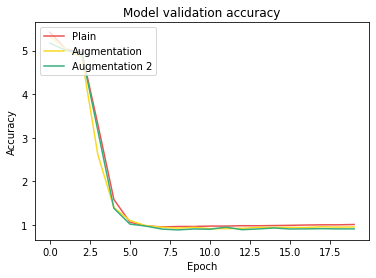

In [41]:
plt.plot(history_resnet50.history['val_loss'], color = '#EB5353')
plt.plot(history_aug_resnet50.history['val_loss'], color = '#F9D923')
plt.plot(history_aug_resnet50_2.history['val_loss'], color = '#36AE7C')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain', 'Augmentation', 'Augmentation 2'], loc='upper left')
plt.show()

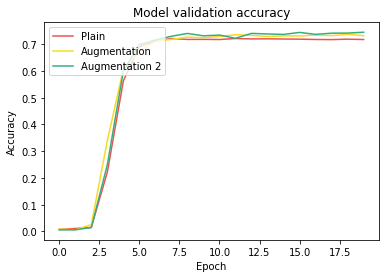

In [40]:
plt.plot(history_resnet50.history['val_accuracy'], color = '#EB5353')
plt.plot(history_aug_resnet50.history['val_accuracy'], color = '#F9D923')
plt.plot(history_aug_resnet50_2.history['val_accuracy'], color = '#36AE7C')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain', 'Augmentation', 'Augmentation 2'], loc='upper left')
plt.show()

#### 순위 (최종 epoch 기준 / val_accuracy)
1. aug2 data - 0.7445
2. aug data - 0.7317
3. plain - 0.7172

<div style = "height: 50px;"></div>

## 6차 - Augmentation 새롭게 적용해보기 2 
<hr/>

<ul>
    <li>batch_size : 64</li>
    <li>augmentation : 랜덤 좌우 뒤집기, 랜덤 대비 조정, 랜덤 hue 조정(max_delta= 0.5), 모든 seed (5, 0)으로 고정 </li>
    <li>lr : 0.01</li>
    <li>EPOCH : 20</li>
</ul>

### Augmentation 함수 조정

In [130]:
def augment3(image, label):
    image = tf.image.stateless_random_flip_left_right(image, seed = (5, 0))
    image = tf.image.stateless_random_contrast(image, 0.2, 0.5, seed = (5, 0))
    image = tf.image.stateless_random_hue(image, max_delta= 0.2, seed = (5, 0))

    return image, label

In [131]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=64, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(augment3)
    ds = ds.batch(batch_size)

    if not is_test and with_cutmix:
        ds = ds.map(cutmix, num_parallel_calls=2)
    
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
        
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

<div style = "height: 50px;"></div>

### 모델 build

In [132]:
aug_resnet50_3 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

<div style = "height: 50px;"></div>

### 데이터 전처리하여 불러오기

In [133]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_aug_3  = apply_normalize_on_dataset(ds_train, with_aug = True)
ds_test         = apply_normalize_on_dataset(ds_test, is_test=True)

<div style = "height: 50px;"></div>

### resnet50(aug3) 모델 훈련

In [134]:
EPOCH = 20

aug_resnet50_3.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_aug_resnet50_2 = aug_resnet50_3.fit(
    ds_train_aug_2,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/64),
    validation_steps=int(ds_info.splits['test'].num_examples/64),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
187/187 [==============================] - 92s 375ms/step - loss: 3.3318 - accuracy: 0.2818 - val_loss: 5.3333 - val_accuracy: 0.0075
Epoch 2/20
187/187 [==============================] - 69s 371ms/step - loss: 1.4371 - accuracy: 0.6302 - val_loss: 5.0757 - val_accuracy: 0.0076
Epoch 3/20
187/187 [==============================] - 69s 371ms/step - loss: 0.9382 - accuracy: 0.7519 - val_loss: 4.8146 - val_accuracy: 0.0273
Epoch 4/20
187/187 [==============================] - 69s 372ms/step - loss: 0.6932 - accuracy: 0.8150 - val_loss: 2.9349 - val_accuracy: 0.2774
Epoch 5/20
187/187 [==============================] - 77s 413ms/step - loss: 0.5303 - accuracy: 0.8645 - val_loss: 1.6411 - val_accuracy: 0.5454
Epoch 6/20
187/187 [==============================] - 69s 371ms/step - loss: 0.4146 - accuracy: 0.8990 - val_loss: 1.1658 - val_accuracy: 0.6608
Epoch 7/20
187/187 [==============================] - 69s 371ms/step - loss: 0.3148 - accuracy: 0.9305 - val_loss: 0.9323 - val_ac

<div style = "height: 50px;"></div>

### 시각화 및 비교 - Plain data, aug 1 data, aug2 data

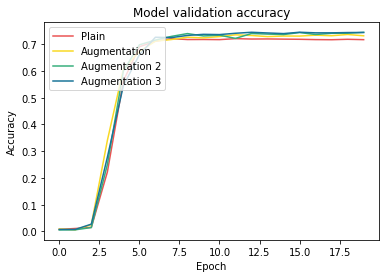

In [135]:
plt.plot(history_resnet50.history['val_accuracy'], color = '#EB5353')
plt.plot(history_aug_resnet50.history['val_accuracy'], color = '#F9D923')
plt.plot(history_aug_resnet50_2.history['val_accuracy'], color = '#36AE7C')
plt.plot(history_aug_resnet50_3.history['val_accuracy'], color = '#187498')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain', 'Augmentation', 'Augmentation 2', 'Augmentation 3'], loc='upper left')
plt.show()

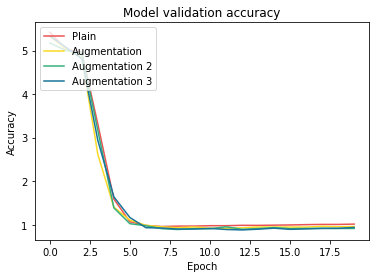

In [136]:
plt.plot(history_resnet50.history['val_loss'], color = '#EB5353')
plt.plot(history_aug_resnet50.history['val_loss'], color = '#F9D923')
plt.plot(history_aug_resnet50_2.history['val_loss'], color = '#36AE7C')
plt.plot(history_aug_resnet50_3.history['val_loss'], color = '#187498')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain', 'Augmentation', 'Augmentation 2', 'Augmentation 3'], loc='upper left')
plt.show()

실수로 loss인데 title을 accuracy로 주었다. 

<div style = "height: 50px;"></div>

### 시각화 및 비교 - 전체

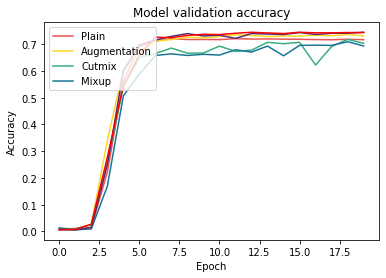

In [138]:
plt.plot(history_resnet50.history['val_accuracy'], color = '#EB5353')
plt.plot(history_aug_resnet50.history['val_accuracy'], color = '#F9D923')
plt.plot(history_cutmix_resnet50.history['val_accuracy'], color = '#36AE7C')
plt.plot(history_mixup_resnet50.history['val_accuracy'], color = '#187498')
plt.plot(history_aug_resnet50_2.history['val_accuracy'], color = '#542E71')
plt.plot(history_aug_resnet50_3.history['val_accuracy'], 'r')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain', 'Augmentation', 'Cutmix', 'Mixup'], loc='upper left')
plt.show()

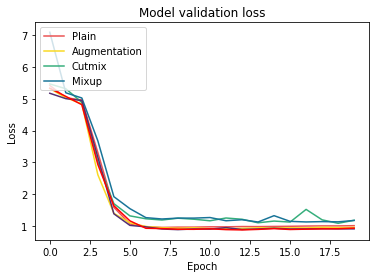

In [137]:
plt.plot(history_resnet50.history['val_loss'], color = '#EB5353')
plt.plot(history_aug_resnet50.history['val_loss'], color = '#F9D923')
plt.plot(history_cutmix_resnet50.history['val_loss'], color = '#36AE7C')
plt.plot(history_mixup_resnet50.history['val_loss'], color = '#187498')
plt.plot(history_aug_resnet50_2.history['val_loss'], color = '#542E71')
plt.plot(history_aug_resnet50_3.history['val_loss'], 'r')

plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Plain', 'Augmentation', 'Cutmix', 'Mixup'], loc='upper left')
plt.show()

<div style = "height: 50px;"></div>

## 7차 - Augmentation 새롭게 적용해보기 3 
<hr/>

<ul>
    <li>batch_size : 64</li>
    <li>augmentation : 랜덤 좌우 뒤집기, 랜덤 hue 조정(max_delta= 0.5)</li>
    <li>lr : 0.01</li>
    <li>EPOCH : 20</li>
</ul>

### Augmentation 함수 조정

In [130]:
def augment4(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_hue(image, max_delta= 0.5)
    return image, label

In [131]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=64, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(augment2)
    ds = ds.batch(batch_size)

    if not is_test and with_cutmix:
        ds = ds.map(cutmix, num_parallel_calls=2)
    
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
        
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

<div style = "height: 50px;"></div>

### 모델 build

In [ ]:
aug_resnet50_4 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

<div style = "height: 50px;"></div>

### 데이터 전처리하여 불러오기

In [133]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_aug_4  = apply_normalize_on_dataset(ds_train, with_aug = True)
ds_test         = apply_normalize_on_dataset(ds_test, is_test=True)

<div style = "height: 50px;"></div>

### resnet50(aug4) 모델 훈련

In [ ]:
EPOCH = 20

aug_resnet50_4.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_aug_resnet50_4 = aug_resnet50_4.fit(
    ds_train_aug_4,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/64),
    validation_steps=int(ds_info.splits['test'].num_examples/64),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
315/315 [==============================] - 103s 245ms/step - loss: 2.7274 - accuracy: 0.3823 - val_loss: 5.0050 - val_accuracy: 0.0084
Epoch 2/20
315/315 [==============================] - 77s 243ms/step - loss: 1.0700 - accuracy: 0.7070 - val_loss: 4.5304 - val_accuracy: 0.0513
Epoch 3/20
315/315 [==============================] - 76s 242ms/step - loss: 0.6899 - accuracy: 0.8146 - val_loss: 1.7468 - val_accuracy: 0.5240
Epoch 4/20
315/315 [==============================] - 83s 262ms/step - loss: 0.4736 - accuracy: 0.8753 - val_loss: 0.9452 - val_accuracy: 0.7153
Epoch 5/20
315/315 [==============================] - 76s 243ms/step - loss: 0.3272 - accuracy: 0.9191 - val_loss: 0.9408 - val_accuracy: 0.7161
Epoch 6/20
315/315 [==============================] - 77s 243ms/step - loss: 0.2247 - accuracy: 0.9529 - val_loss: 0.9134 - val_accuracy: 0.7268
Epoch 7/20
315/315 [==============================] - 77s 243ms/step - loss: 0.1545 - accuracy: 0.9715 - val_loss: 0.8930 - val_a

<div style = "height: 50px;"></div>

# <span style = "font-weight:bold;color:#0172d4;">STEP 5</span> 결과 및 회고

모든 결과는 epoch 중 가장 높은 accuracy값을 기준으로 한다.

<div style = "height: 50px;"></div>

### 시각화 및 비교 - Plain data, aug 1 data, aug2 data

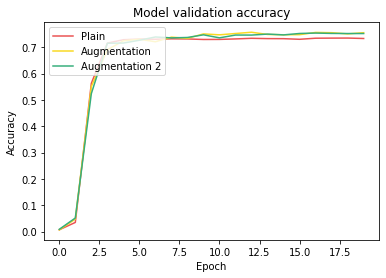

In [ ]:
plt.plot(history_resnet50.history['val_accuracy'], color = '#EB5353')
plt.plot(history_aug_resnet50.history['val_accuracy'], color = '#F9D923')
plt.plot(history_aug_resnet50_4.history['val_accuracy'], color = '#36AE7C')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain', 'Augmentation', 'Augmentation 2'], loc='upper left')
plt.show()

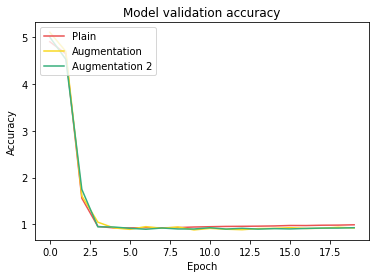

In [ ]:
plt.plot(history_resnet50.history['val_loss'], color = '#EB5353')
plt.plot(history_aug_resnet50.history['val_loss'], color = '#F9D923')
plt.plot(history_aug_resnet50_2.history['val_loss'], color = '#36AE7C')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain', 'Augmentation', 'Augmentation 2'], loc='upper left')
plt.show()

실수로 loss인데 title을 accuracy로 주었다. 

### 시각화 및 비교 - 전체

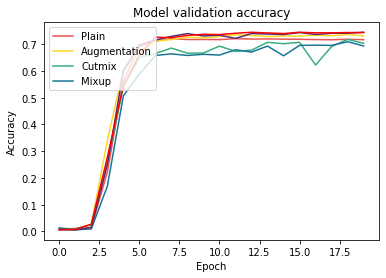

In [138]:
plt.plot(history_resnet50.history['val_accuracy'], color = '#EB5353')
plt.plot(history_aug_resnet50.history['val_accuracy'], color = '#F9D923')
plt.plot(history_cutmix_resnet50.history['val_accuracy'], color = '#36AE7C')
plt.plot(history_mixup_resnet50.history['val_accuracy'], color = '#187498')
plt.plot(history_aug_resnet50_2.history['val_accuracy'], color = '#542E71')
plt.plot(history_aug_resnet50_3.history['val_accuracy'], 'r')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain', 'Augmentation', 'Cutmix', 'Mixup'], loc='upper left')
plt.show()

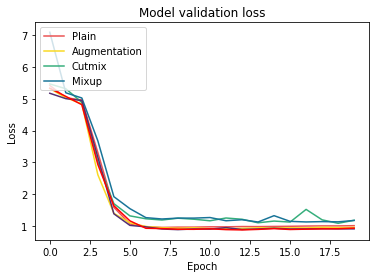

In [137]:
plt.plot(history_resnet50.history['val_loss'], color = '#EB5353')
plt.plot(history_aug_resnet50.history['val_loss'], color = '#F9D923')
plt.plot(history_cutmix_resnet50.history['val_loss'], color = '#36AE7C')
plt.plot(history_mixup_resnet50.history['val_loss'], color = '#187498')
plt.plot(history_aug_resnet50_2.history['val_loss'], color = '#542E71')
plt.plot(history_aug_resnet50_3.history['val_loss'], 'r')

plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Plain', 'Augmentation', 'Cutmix', 'Mixup'], loc='upper left')
plt.show()

<div style = "height: 25px;"></div>

## 1. Best 모델
<hr/>

Plain data로 학습한 모델과 비교했을 때 가장 좋은 성능을 보인 모델은, aug4 data를 학습한 모델이며, 0.7540을 달성하였다. 이는 Plain 모델에 비해 약 4%의 성능 향상을 보였다.

<div style = "height: 50px;"></div>

## 2. 성능 향상 기대 방법
<hr/>

준병님께선 Plain data와 aug data를 학습한 모델간 성과가 5% 이상 났다고 하여 이야기를 들어보니, cutmix한 데이터를 다시 한번 더 augmentation하여 학습을 진행하였다고 한다.

## 2. 개선방향

<div style = "height: 50px;"></div>

## 3. 아쉬운점
<hr/>

cutmix는 데이터들의 구도, 객체 수, 크기 등을 고려하지 않은 채로 진행해서 그런지, 강아지 얼굴 위치에 사람 얼굴이 들어가거나, 건물 외벽이 들어가는 등 모델 학습에 악영향을 미칠 것 같은 사진이 몇몇개 출력됨을 확인할 수 있었다. 

개인적인 생각으로는 이 데이터셋에는 적합하지 않은 방법인가 생각도 든다.

<div style = "height: 50px;"></div>